In [44]:
"""IMPORT EVERYTHING.. """
# Data manipulation
import pandas as pd
import numpy as np

# Quantitative analysis / indicators
import talib
import backtrader as bt

# # Machine learning / statistics
# import scipy
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

# # Visualization
# import matplotlib.pyplot as plt
# import seaborn as sns
import mplfinance as mpf

# # Jupyter Notebook magic for inline plots
# %matplotlib inline


In [45]:
df = pd.read_parquet("../Src/filtered.XAUUSD-M1.parquet", engine="pyarrow")

# print(df.head(3))

In [46]:
from tafm import EnhancedTechnicalAnalyzer, create_analyzer, IndicatorConfig

df.rename(columns={
    'OPEN': 'Open',
    'HIGH': 'High',
    'LOW': 'Low',
    'CLOSE': 'Close',
    'VOL': 'Volume'
}, inplace=True)

def example_basic_indicators(df):
    """Example: Adding technical indicators"""

    # Initialize analyzer
    analyzer = create_analyzer(df)

    # Add indicators using fluent interface
    analyzer.add_indicator(
        IndicatorConfig(name='EMA', period=21)
    ).add_indicator(
        IndicatorConfig(name='EMA', period=50)
    ).add_indicator(
        IndicatorConfig(name='RSI', period=14)
    ).add_indicator(
        IndicatorConfig(name='MACD', fast_period=12, slow_period=26, signal_period=9)
    )

    analyzer.crossed_down('EMA_21', 'EMA_50', 'Cross_e2150')

    # View results
    print("DataFrame with indicators:")
    print(analyzer.df[['Close', 'EMA_21', 'EMA_50', 'RSI_14', 'MACD']].tail())

    # Get summary
    print("\nOperations Summary:")
    print(analyzer.summary())

    return analyzer

signal = example_basic_indicators(df)

2025-10-10 09:14:29,336 - INFO - OHLCV validation: {'Open': True, 'High': True, 'Low': True, 'Close': True, 'Volume': True}
2025-10-10 09:14:29,453 - INFO - Initialized analyzer - Shape: (351641, 5), Memory: 14.08MB
2025-10-10 09:14:32,426 - INFO - [OK] Added indicator EMA_21 in 2.9695s
2025-10-10 09:14:32,915 - INFO - [OK] Added indicator EMA_50 in 0.4874s
2025-10-10 09:14:33,412 - INFO - [OK] Added indicator RSI_14 in 0.4956s
2025-10-10 09:14:33,907 - INFO - [OK] Added indicator MACD in 0.4945s
2025-10-10 09:14:33,921 - INFO - [ OK ] EMA_21 crossed_down EMA_50 -> Cross_e2150 (0.0119s)


DataFrame with indicators:
                        Close       EMA_21       EMA_50     RSI_14      MACD
DATETIME                                                                    
2024-12-31 21:53:00  2624.517  2624.319708  2624.090799  60.272985  0.113984
2024-12-31 21:54:00  2624.468  2624.333189  2624.105591  57.936532  0.111753
2024-12-31 21:55:00  2624.438  2624.342718  2624.118626  56.492635  0.106339
2024-12-31 21:56:00  2624.475  2624.354743  2624.132602  57.886653  0.103836
2024-12-31 21:57:00  2624.381  2624.357130  2624.142343  53.221128  0.093194

Operations Summary:
                    Operation       Column  Success  Execution_Time_ms  \
0           ADD_INDICATOR_EMA       EMA_21     True            2969.45   
1           ADD_INDICATOR_EMA       EMA_50     True             487.36   
2           ADD_INDICATOR_RSI       RSI_14     True             495.56   
3          ADD_INDICATOR_MACD         MACD     True             494.53   
4  EMA_21 crossed_down EMA_50  Cross_e2150 

In [47]:
signal.df[signal.df['Cross_e2150'] == 1]

,Open,High,Low,Close,Volume,EMA_21,EMA_50,RSI_14,MACD,Cross_e2150
DATETIME,,,,,,,,,,
2024-01-02 01:59:00,2066.548,2066.626,2066.290,2066.536,1,2067.275804,2067.296045,34.606243,-0.316640,1
2024-01-02 04:55:00,2069.146,2069.162,2068.954,2069.032,1,2069.558279,2069.571000,36.462001,-0.137486,1
2024-01-02 07:04:00,2073.830,2074.212,2073.231,2074.165,1,2074.435920,2074.450799,45.143058,-0.178688,1
2024-01-02 07:55:00,2074.787,2075.217,2074.787,2074.801,1,2074.978650,2074.985327,46.340804,-0.084195,1
2024-01-02 10:14:00,2074.707,2074.966,2074.483,2074.966,1,2076.420425,2076.457564,31.329198,-0.550801,1
...,...,...,...,...,...,...,...,...,...,...
2024-12-31 10:02:00,2614.305,2614.318,2613.644,2613.900,109,2615.026928,2615.067214,33.318441,-0.145689,1
2024-12-31 13:04:00,2609.482,2609.676,2608.742,2608.912,110,2610.817971,2610.921908,30.059350,-0.324526,1
2024-12-31 14:28:00,2611.532,2611.817,2611.278,2611.369,122,2612.303096,2612.351227,38.000374,-0.275346,1


In [48]:
from resampler import OHLCVResampler

# Resample to 1 hour - all columns preserved
resampler = OHLCVResampler(default_agg='last')


result = resampler.resample(signal.df, '1min', '2024-11-01', '2024-11-02')


result.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)



print(f"\nResampled shape: {result.shape}")

Cross_e2150 = result[result['Cross_e2150']==1].index

vline_series = pd.Series(np.nan, index=result.index)
vline_series.loc[Cross_e2150] = 1

result


Resampled shape: (1258, 10)


,open,high,low,close,volume,EMA_21,EMA_50,RSI_14,MACD,Cross_e2150
DATETIME,,,,,,,,,,
2024-11-01 00:00:00,2746.672,2747.097,2745.759,2746.206,107,2746.694551,2746.701344,40.872200,-0.153766,1
2024-11-01 00:01:00,2746.118,2746.494,2745.806,2746.494,80,2746.676319,2746.693213,46.280187,-0.148516,0
2024-11-01 00:02:00,2746.491,2746.642,2745.958,2746.164,75,2746.629745,2746.672460,41.586613,-0.169034,0
2024-11-01 00:03:00,2746.171,2746.472,2746.099,2746.354,60,2746.604677,2746.659971,45.042503,-0.168027,0
2024-11-01 00:04:00,2746.397,2747.219,2746.322,2747.130,80,2746.652434,2746.678404,56.390544,-0.103420,0
...,...,...,...,...,...,...,...,...,...,...
2024-11-01 20:53:00,2735.217,2735.274,2735.070,2735.074,39,2734.668284,2734.500058,59.872145,0.218178,0
2024-11-01 20:54:00,2735.067,2735.341,2734.950,2735.256,84,2734.721713,2734.529703,62.680417,0.236403,0
2024-11-01 20:55:00,2735.217,2735.984,2735.090,2735.892,86,2734.828102,2734.583126,70.460254,0.298723,0


In [49]:

from ChartterX5 import Chartter

chartter = Chartter(config={
    'chart_type': 'candle',
    'style': 'charles',
    'volume': False
})

chartter._setup_tradingview_theme()

cnf = {
        'title': 'NONE',
        'style': chartter.tradingview_style,
        'volume': False,
        'show_nontrading': False,
        'datetime_format': '%Y-%m-%d',
        'xlabel': '',
        'ylabel': '',
        'xrotation': 0
    }
# result.head(3)

2025-10-10 09:14:34,343 - INFO - Generating chart 6e3d8023-e8ed-4986-a02e-04148054c6d8 with 1258 data points
2025-10-10 09:14:34,620 - INFO - Chart 6e3d8023-e8ed-4986-a02e-04148054c6d8 generated successfully in 0.28s


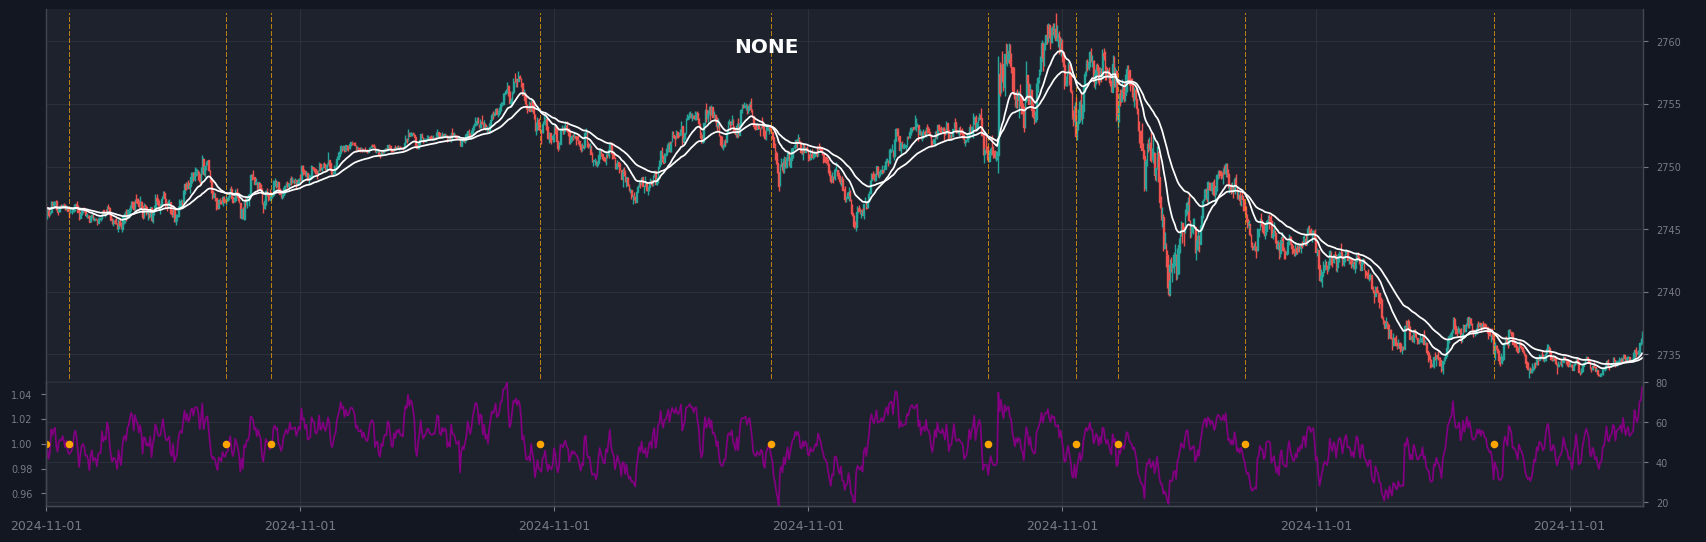

In [50]:
# Create base chart
fig, axes =chartter.plot(
    result,
    addplot=[
        mpf.make_addplot(result['RSI_14'], panel=1, color='purple', ylabel='RSI'),
        mpf.make_addplot(result['EMA_21'], panel=0, color='white', ylabel='RSI'),
        mpf.make_addplot(result['EMA_50'], panel=0, color='white', ylabel='RSI'),
        mpf.make_addplot(vline_series,panel=1,type='scatter',markersize=20,color='orange')
    ],
    config=cnf,
    vlines = {
        'vlines': Cross_e2150.to_list(),
        'colors': 'orange',
        'linewidths': 0.9,
        'linestyle': '--',
        'alpha': 0.7
    },
    returnfig=True
)